This notebook shows the performance of a neural network to classify speckles patterns
into 10 different classes. The problem that the network faces is the following: 
We propagate images of 10 digits into an optical fiber and we record images of the light at the end of the fiber (the speckle patterns). For humans, the resulting images look nothing like digits and it would be impossible for us to tell which digit was being propagated. The neural network however finds correlation between the input and output and manages to correctly assign a number to each speckle pattern.


# HDF5 file input/output

## Import python libraries

In [0]:
# Import python libraries

import h5py   # HDF5 data file management library

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

##Mount google drive locally to the virtual machine

In [2]:
# Mount google drive to virtual machine using an authorization code

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Define helper functions for notebook

In [0]:
# function to display a grayscale image

def show_image_gray(image, title):

    import matplotlib.pyplot as plt    
    
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()
    
    return

## Read data from compressed HDF5 and numpy save files

data_path :  /content/gdrive/My Drive/Colab Notebooks/HM7/mnist_mmf_phase_intensity_10m/

input_data :  (20000, 32, 32, 1) float32
output_class :  (20000,) uint16
output_class_onehot :  (20000, 10) float32
output_class_names :  (10,) <U1

output_class_names :  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']

total number of data items :  20000
input size [pixels] :  32 x 32
number of input channels :  1
number of output classes :  10



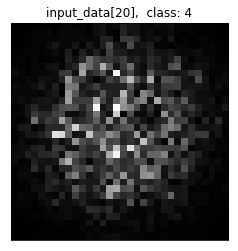

In [4]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/HM7/mnist_mmf_phase_intensity_10m/'  # nb: begin with /  for windows //
print('data_path : ', data_path)
print()
#content/gdrive/My Drive/Colab Notebooks/HM7/mnist_mmf_phase_intensity_10m
input_data_filename = data_path + 'input_data.h5'
output_class_filename = data_path + 'output_class.h5'
output_class_onehot_filename = data_path + 'output_class_onehot.h5'
output_class_names_filename = data_path + 'output_class_names.npy'

hf = h5py.File(input_data_filename, 'r')
temp = hf.get('input_data')
input_data = np.array(temp)
hf.close()

hf = h5py.File(output_class_filename, 'r')
temp = hf.get('output_class')
output_class = np.array(temp)
hf.close()

hf = h5py.File(output_class_onehot_filename, 'r')
temp = hf.get('output_class_onehot')
output_class_onehot = np.array(temp)
hf.close()

output_class_names = np.load(output_class_names_filename)

print('input_data : ', input_data.shape, input_data.dtype)
print('output_class : ', output_class.shape, output_class.dtype)
print('output_class_onehot : ', output_class_onehot.shape, output_class_onehot.dtype)
print('output_class_names : ', output_class_names.shape, output_class_names.dtype)
print()
print('output_class_names : ', output_class_names)
print()

n_data_items = input_data.shape[0]
input_xsize = input_data.shape[1]
input_ysize = input_data.shape[2]
n_input_channels = input_data.shape[3]
n_output_classes = output_class_onehot.shape[1]

print('total number of data items : ', n_data_items)
print('input size [pixels] : ', input_xsize, 'x', input_ysize)
print('number of input channels : ', n_input_channels)
print('number of output classes : ', n_output_classes)
print()

# show example of dataset

data_item = 20
show_image_gray(input_data[data_item, :, :, 0],  \
                title='input_data[' + str(data_item) + '],  class: ' + output_class_names[output_class[data_item]])

##Split dataset into [test] and [train + valid] subsets using sklearn

In [5]:
# Split data set into [test] and [train+valid] subsets using sklearn train_test_split function

data_set_test_trainvalid_ratio = 0.1
data_split_state = None   # integer (usually 42) or None for random split on each call

print('test:[train+valid] split ratio : ', data_set_test_trainvalid_ratio)
print('data_split_state : ', data_split_state)
print()

input_trainvalid, input_test, output_class_onehot_trainvalid, output_class_onehot_test =  \
    train_test_split(input_data, output_class_onehot, \
                     test_size=data_set_test_trainvalid_ratio, random_state=data_split_state)

print('input_data : ', input_data.shape, input_data.dtype)
print('input_trainvalid : ', input_trainvalid.shape, input_trainvalid.dtype)
print('input_test : ', input_test.shape, input_test.dtype)
print()
print('output_class_onehot : ', output_class_onehot.shape, output_class_onehot.dtype)
print('output_class_onehot_trainvalid : ', output_class_onehot_trainvalid.shape, output_class_onehot_trainvalid.dtype)
print('output_class_onehot_test : ', output_class_onehot_test.shape, output_class_onehot_test.dtype)


test:[train+valid] split ratio :  0.1
data_split_state :  None

input_data :  (20000, 32, 32, 1) float32
input_trainvalid :  (18000, 32, 32, 1) float32
input_test :  (2000, 32, 32, 1) float32

output_class_onehot :  (20000, 10) float32
output_class_onehot_trainvalid :  (18000, 10) float32
output_class_onehot_test :  (2000, 10) float32


##PART 1: Implement VGG CNN to classify the speckle images.


W0823 07:57:57.276432 140182977599360 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



* Compiling the network model *

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)          

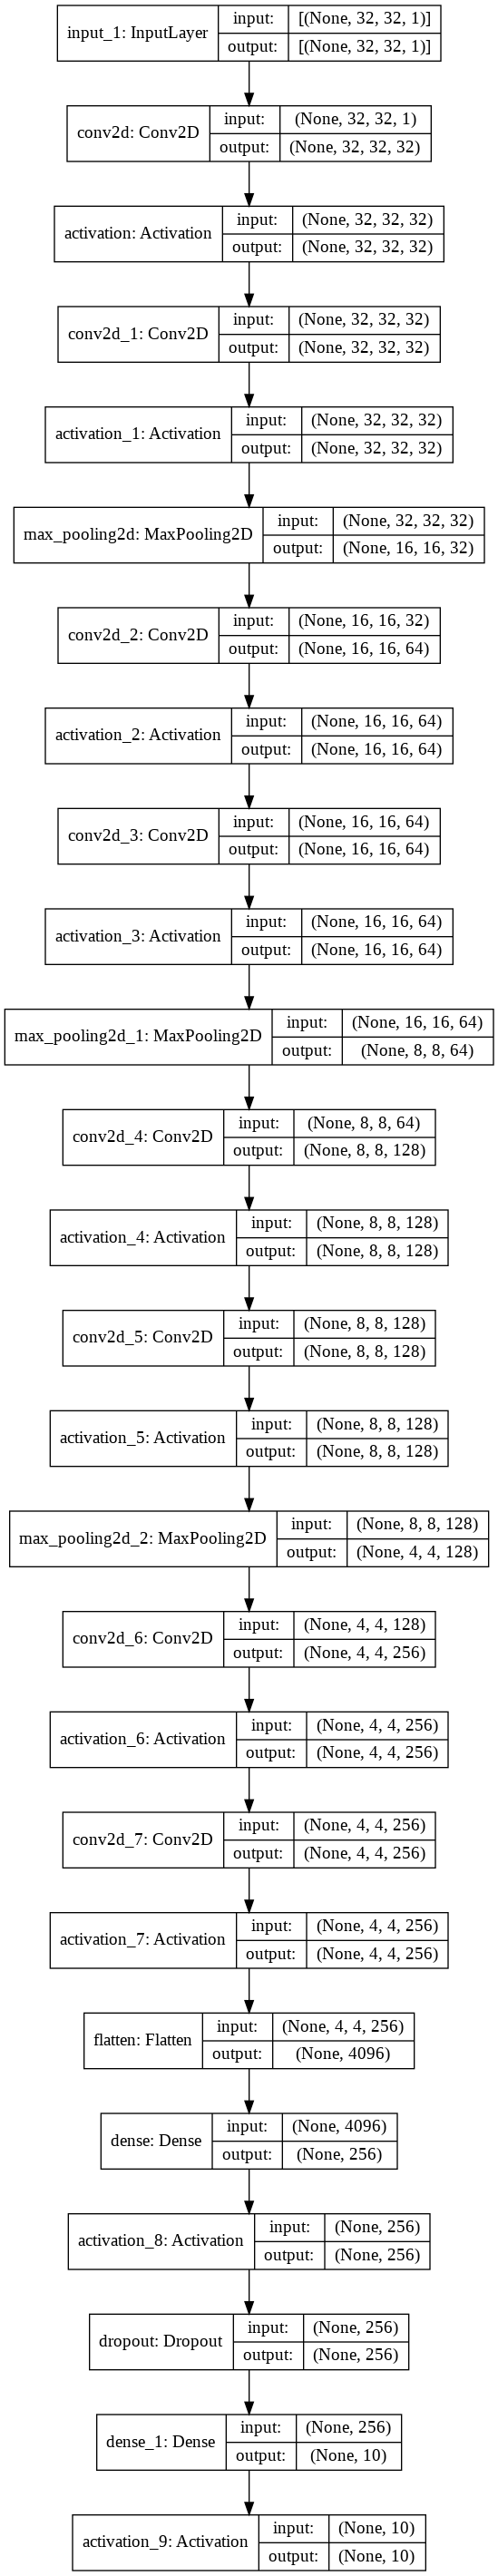

In [6]:
## PART 1


#define network hyperparameters

optimizer_type = Adam(lr=0.0001)  # optimisation algorithm: Adam
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['categorical_accuracy']  # network accuracy metric to be determined after each epoch
dropout_ratio = 0.0  # % of nodes in the hidden layer to dropout during back-propagation update of the network weights
validtrain_split_ratio = 0.1  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 40  # maxmimum number of epochs to be iterated
batch_size = 500   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
num_hidden_nodes = 256  # number of nodes in hidden fully connected layer

#Define network architecture
input_shape = (32, 32, 1)
inputs = Input(shape=input_shape)

down_01 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
down_01 = Activation('relu')(down_01)
down_01 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_01)
down_01 = Activation('relu')(down_01)

down_01_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_01)   # maxpool downsampled to 16x16x32

down_02 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_01_pool)
down_02 = Activation('relu')(down_02)
down_02 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_02)
down_02 = Activation('relu')(down_02)

down_02_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_02)   # maxpool downsampled to 8x8x32


down_03 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_02_pool)
down_03 = Activation('relu')(down_03)
down_03= Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_03)
down_03 = Activation('relu')(down_03)

down_03_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_03)   # maxpool downsampled to 4x4x128



down_04 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_03_pool)
down_04 = Activation('relu')(down_04)
down_04= Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(down_04)
down_04 = Activation('relu')(down_04)



flatten = Flatten()(down_04)   # 1568 nodes

dense_01 = Dense(num_hidden_nodes)(flatten)
dense_01 = Activation('sigmoid')(dense_01)
dense_01 = Dropout(dropout_ratio)(dense_01)

dense_02 = Dense(10)(dense_01)
outputs = Activation('softmax')(dense_02)

#compile network

print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()

# create and save a schematic image of the network architecture

from tensorflow.keras.utils import plot_model
from IPython.display import Image

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')


### train network

In [9]:
print('* Training the compiled network *')
print()

history = model.fit(input_trainvalid, output_class_onehot_trainvalid, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)
model.save("VGG_CNN_SPECKLE.h5")
print()
print('Training completed')
print()

* Training the compiled network *

Train on 16200 samples, validate on 1800 samples
Epoch 1/40
16200/16200 [==============================] - 172s 11ms/sample - loss: 0.0320 - categorical_accuracy: 0.7894 - val_loss: 0.0341 - val_categorical_accuracy: 0.7667
Epoch 2/40
16200/16200 [==============================] - 172s 11ms/sample - loss: 0.0290 - categorical_accuracy: 0.8121 - val_loss: 0.0303 - val_categorical_accuracy: 0.7994
Epoch 3/40
16200/16200 [==============================] - 173s 11ms/sample - loss: 0.0261 - categorical_accuracy: 0.8340 - val_loss: 0.0293 - val_categorical_accuracy: 0.8017
Epoch 4/40
16200/16200 [==============================] - 172s 11ms/sample - loss: 0.0235 - categorical_accuracy: 0.8527 - val_loss: 0.0275 - val_categorical_accuracy: 0.8122
Epoch 5/40
16200/16200 [==============================] - 172s 11ms/sample - loss: 0.0215 - categorical_accuracy: 0.8648 - val_loss: 0.0254 - val_categorical_accuracy: 0.8283
Epoch 6/40
16200/16200 [=================

### plot training history

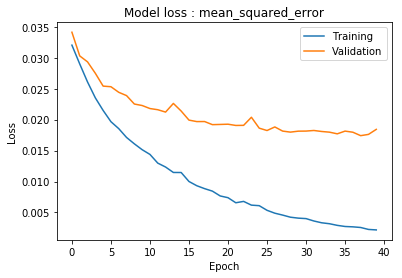

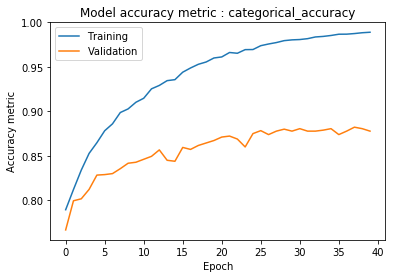

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

###evaluate on test set

In [11]:
print('* Evaluating the performance of the trained network on the test dataset *')
print()

evaluate_model = model.evaluate(x=input_test, y=output_class_onehot_test)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)







* Evaluating the performance of the trained network on the test dataset *

2000/2000 [==============================] - 5s 3ms/sample - loss: 0.0166 - categorical_accuracy: 0.8855

Accuracy - categorical_accuracy: 0.886
Loss - mean_squared_error: 0.017


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6


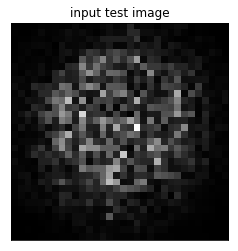

The label of the speckle image is 6
the predicted label is 6


In [16]:
output_predict_class = model.predict(input_test)

print(output_class_onehot_test[105])
print(np.argmax(output_predict_class[105]))

#np.shape(input_test[105])
show_image_gray(input_test[105][:,:,0], "input test image")
print("The label of the speckle image is {}".format(np.argmax(output_class_onehot_test[105])))
print("the predicted label is {}".format(np.argmax(output_predict_class[105])))

In [0]:
np.shape(input_test)
np.shape(output_predict_image)

## PART 2: Implement a fully connected network with one hidden layer to classify the same speckle images. 


* Compiling the network model *

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_11 (Activation

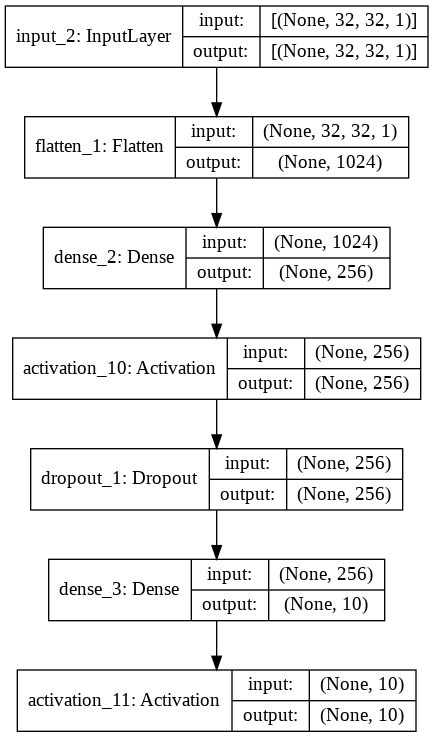

In [17]:
#define network hyperparameters

optimizer_type = Adam(lr=0.0001)  # optimisation algorithm: Adam
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['categorical_accuracy']  # network accuracy metric to be determined after each epoch
dropout_ratio = 0.0  # % of nodes in the hidden layer to dropout during back-propagation update of the network weights
validtrain_split_ratio = 0.1  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 40  # maxmimum number of epochs to be iterated
batch_size = 500   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
num_hidden_nodes = 256  # number of nodes in hidden fully connected layer

#Define network architecture
input_shape = (32, 32, 1)
inputs = Input(shape=input_shape)



flatten = Flatten()(inputs)   # 1568 nodes

dense_01 = Dense(num_hidden_nodes)(flatten)
dense_01 = Activation('sigmoid')(dense_01)
dense_01 = Dropout(dropout_ratio)(dense_01)

dense_02 = Dense(10)(dense_01)
outputs = Activation('softmax')(dense_02)

#compile network

print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()

# create and save a schematic image of the network architecture

from tensorflow.keras.utils import plot_model
from IPython.display import Image

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')


### train network

In [18]:
print('* Training the compiled network *')
print()

history2 = model.fit(input_trainvalid, output_class_onehot_trainvalid, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Train on 16200 samples, validate on 1800 samples
Epoch 1/40
16200/16200 [==============================] - 1s 48us/sample - loss: 0.0902 - categorical_accuracy: 0.1670 - val_loss: 0.0873 - val_categorical_accuracy: 0.2561
Epoch 2/40
16200/16200 [==============================] - 1s 42us/sample - loss: 0.0860 - categorical_accuracy: 0.2720 - val_loss: 0.0847 - val_categorical_accuracy: 0.3033
Epoch 3/40
16200/16200 [==============================] - 1s 40us/sample - loss: 0.0834 - categorical_accuracy: 0.3293 - val_loss: 0.0823 - val_categorical_accuracy: 0.3383
Epoch 4/40
16200/16200 [==============================] - 1s 37us/sample - loss: 0.0806 - categorical_accuracy: 0.3684 - val_loss: 0.0792 - val_categorical_accuracy: 0.3939
Epoch 5/40
16200/16200 [==============================] - 1s 35us/sample - loss: 0.0779 - categorical_accuracy: 0.4143 - val_loss: 0.0766 - val_categorical_accuracy: 0.4333
Epoch 6/40
16200/16200 [===========================

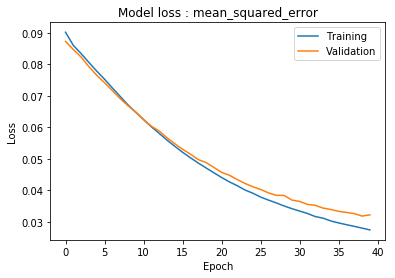

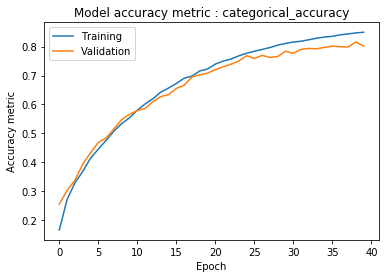

In [19]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history2.history[metrics[0]]))
plt.plot(np.array(history2.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

###Test network on unseen data

In [20]:
print('* Evaluating the performance of the trained network on the test dataset *')
print()

evaluate_model = model.evaluate(x=input_test, y=output_class_onehot_test)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the test dataset *

2000/2000 [==============================] - 0s 58us/sample - loss: 0.0314 - categorical_accuracy: 0.7985

Accuracy - categorical_accuracy: 0.799
Loss - mean_squared_error: 0.031


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8


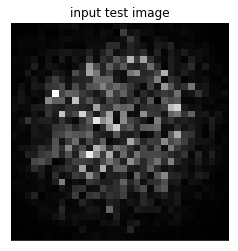

The label of the speckle image is 8
the predicted label is 8


In [21]:
output_predict_class = model.predict(input_test)
id = 95
print(output_class_onehot_test[id])
print(np.argmax(output_predict_class[id]))

#np.shape(input_test[105])
show_image_gray(input_test[id][:,:,0], "input test image")
print("The label of the speckle image is {}".format(np.argmax(output_class_onehot_test[id])))
print("the predicted label is {}".format(np.argmax(output_predict_class[id])))

## Write data to compressed HDF5 files

In [22]:
save_path = data_path

print('save_path : ', save_path)
print()

array_data = input_test
array_name = 'input_test'
filename = save_path + array_name + '.h5'

print('filename : ', filename)

hf = h5py.File(filename, 'w')
hf.create_dataset(array_name, data=array_data, compression='gzip')
hf.close()

save_path :  /content/gdrive/My Drive/Colab Notebooks/HM7/mnist_mmf_phase_intensity_10m/

filename :  /content/gdrive/My Drive/Colab Notebooks/HM7/mnist_mmf_phase_intensity_10m/input_test.h5
